# Learning and Decision Making

## Laboratory 5: Reinforcement learning

In the end of the lab, you should submit all code/answers written in the tasks marked as "Activity n. XXX", together with the corresponding outputs and any replies to specific questions posed to the e-mail <adi.tecnico@gmail.com>. Make sure that the subject is of the form [&lt;group n.&gt;] LAB &lt;lab n.&gt;.

### 1. The puddle world domain

Consider the puddleworld domain from the homework, depicted in the figure below.

<img src="puddleworld.png" width="400px">

In it, an all terrain vehicle must navigate a 20 &times; 20 gridworld. The three shaded cells in the upper right corner correspond to the goal state, while the L-shaped shaded cells in the middle of the grid correspond to a puddle in which the vehicle may get stuck and damaged. 

The vehicle has available the standard four actions, _up_, _down_, _left_ and _right_. Each action

* Succeeds and moves the vehicle to the adjacent cell in the corresponding direction with a probability of $0.92$; 
* Fails and moves the vehicle to any of the other 3 adjacent cells with a probability of $0.2$; 
* Fails and the vehicle remains in the same cell with a probability of $0.2$.

The vehicle incurs maximal cost ($1$) for standing in the darker part of the puddle; in the lighter part of the puddle, it incurs a cost of $0.5$. Each movement costs $0.05$ and the goal cells cost $0$.

The problem can be described as an MDP $(\mathcal{X},\mathcal{A},\mathbf{P},c,\gamma)$ as follows.

<IPython.core.display.Javascript object>


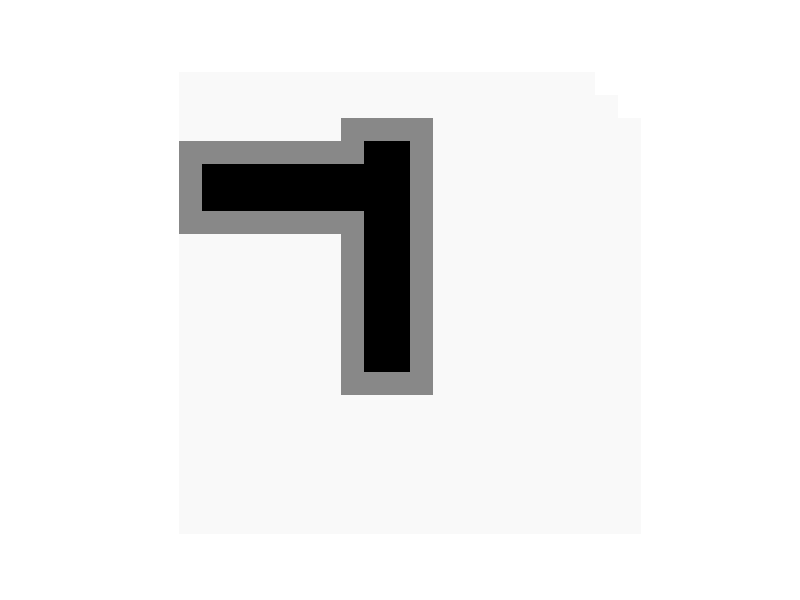

In [79]:
%matplotlib notebook
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import time as t

# Problem specific parameters
GRIDSIZE = 20

def puddlecost(x):
    ''' puddlecost : int -> int

        puddlecost(x) returns the cost for the puddle area corresponding to state x:
        * if x is in the dark puddle area, it returns 1;
        * if x is in the light puddle area, it returns 0.5;
        * otherwise, it returns 0.
        
    '''

    i = x // GRIDSIZE
    j = x % GRIDSIZE
    
    if (j in (4, 5) and i in range(1, 8)) or \
       (i in (8, 9) and j in range(3, 13)):
        return 1.0
    
    if (j in range(3, 7) and i in range(0, 9)) or \
       (i in range(7, 11) and j in range(2, 14)):
        return 0.5
    
    return 0

# -- End: puddlecost


np.set_printoptions(threshold=10)


# States
X = [(i, j) for i in range(GRIDSIZE) for j in range(GRIDSIZE)]
nX = len(X)

# Actions
A = ['U', 'D', 'L', 'R']
nA = len(A)

# Transition probabilities and cost
Pu = np.zeros((nX, nX))
Pd = np.zeros((nX, nX))
Pl = np.zeros((nX, nX))
Pr = np.zeros((nX, nX))

c = np.zeros((nX, nA))

for x in range(nX):
    (i, j) = X[x]
    
    xu = X.index((i, max(j - 1, 0)))
    xd = X.index((i, min(j + 1, GRIDSIZE - 1)))
    xl = X.index((max(i - 1, 0), j))
    xr = X.index((min(i + 1, GRIDSIZE - 1), j))
    
    # Successfull transition
    Pu[x, xu] += 0.92
    Pd[x, xd] += 0.92
    Pl[x, xl] += 0.92
    Pr[x, xr] += 0.92

    # Failed transition (stays in place)
    Pu[x, x] += 0.02
    Pd[x, x] += 0.02
    Pl[x, x] += 0.02
    Pr[x, x] += 0.02

    # Failed transition (oposite direction)
    Pu[x, xd] += 0.02
    Pd[x, xu] += 0.02
    Pl[x, xr] += 0.02
    Pr[x, xl] += 0.02

    # Failed transition (sideways)
    Pu[x, xl] += 0.02
    Pu[x, xr] += 0.02
    Pd[x, xl] += 0.02
    Pd[x, xr] += 0.02
    Pl[x, xu] += 0.02
    Pl[x, xd] += 0.02
    Pr[x, xu] += 0.02
    Pr[x, xd] += 0.02
    
    if x not in (GRIDSIZE * (GRIDSIZE - 2), GRIDSIZE * (GRIDSIZE - 1), GRIDSIZE * (GRIDSIZE - 1) + 1):
        c[x, :] = min(0.05 + puddlecost(x), 1)
    
P = [Pu, Pd, Pl, Pr]

# Discount
gamma = 0.95

# Observe cost function
fig1 = plt.figure()

plt.imshow(c[:, 0].reshape(GRIDSIZE, GRIDSIZE).T, cmap='Greys', origin='upper')
plt.axis('off')
fig1.show()

---

#### Activity 1.        

Compute the optimal $Q$-function for the MDP defined above using value iteration. As your stopping condition, use an error between iterations smaller than `1e-8`.

---

In [29]:
def create_MDP(X, A, Pa, C):
    def create_trans_A(A, Pa):
        result = {}
        for i in range(len(A)):
            result[A[i]] = Pa[i]

        return result


    return  {"X": X, "A": A,\
             "Pa": create_trans_A(A,Pa), "C": C\
            }

def get_X(MDP):
    return MDP.get("X")

def get_A(MDP):
    return MDP.get("A")

def get_Pa(MDP, a):
    return MDP.get("Pa").get(a)

def get_C(MDP):
    return MDP.get("C")


def valueIterationQ(MDP, tolerance, gamma):
    J = np.zeros((len(get_X(MDP)), 1))  # initialize J
    err = 1
    i = 0
    while err > tolerance:

        Qa = [None] * len(get_A(MDP))  # initialize empty list for Q values for actions a in A

        for a in range(len(get_A(MDP))):
            el = get_A(MDP)[a]
            Qa[a] = get_C(MDP)[:, [a]] + gamma * get_Pa(MDP, el).dot(J)

        Jnew = np.min(([column for column in Qa]), axis=0)
        err = np.linalg.norm(Jnew - J)
        i += 1
        J = Jnew

    # this extra cycle is just for formating Q based on the Qa values computed
    Q = np.zeros((len(get_X(MDP)), len(get_A(MDP))))
    for a in range(len(get_A(MDP))):
        Q[:, a] = Qa[a][:, 0]

    return (Q, i)

Pa = [Pu, Pd, Pl, Pr]

MDP = create_MDP(X, A, Pa, c)

gamma = gamma
tolerance = 1e-8

Q_opt, iteracoes = valueIterationQ(MDP, tolerance, gamma)
print("The optimal Q-function is:\n{}\n with {} iterations".format(Q_opt, iteracoes))

The optimal Q-function is:
[[ 0.6226464   0.64151408  0.6226464   0.60278568]
 [ 0.6226464   0.6226464   0.64151408  0.6226464 ]
 [ 0.64151408  1.15146646  0.65943837  1.15146646]
 ..., 
 [ 0.55987333  0.60278568  0.60278568  0.58187966]
 [ 0.58187966  0.6226464   0.6226464   0.60278568]
 [ 0.60278568  0.6226464   0.64151408  0.6226464 ]]
 with 42 iterations


---

#### Activity 2.        

Write down a Python function that, given a Q-function $Q$ and a state $x$, selects a random action using the $\epsilon$-greedy policy obtained from $Q$ for state $x$. Your function should receive an optional parameter, corresponding to $\epsilon$, with default value of 0.1. 

**Note:** In the case of two actions with the same value, your $\epsilon$-greedy policy should randomize between the two.

---

In [53]:
import random

eps=0.1

def unique(vec,val):
    count=[]
    for l in range(0,len(vec)):
        if vec[l]==val:
            count.append(l)
    return count

def greedy(Q,x,eps):
    prob=np.random.rand(1)
    if prob<eps:
        action=np.random.choice(range(0,len(A)),1)
    else:
        vec=Q[X.index(x)]
        max_index=min(vec)
        list_act=unique(vec,max_index)
        if len(list_act)==1:
            action=list_act
        else:
            action=np.random.choice(list_act,1)

    return A[action[0]]

### 2. Model-based learning

You will now run the model-based learning algorithm discussed in class, and evaluate its learning performance.

---

#### Activity 3.        

Run the model-based reinforcement learning algorithm discussed in class to compute $Q^*$ for $500,000$ iterations. Initialize each transition probability matrix as the identity and the cost function as all-zeros. Use an $\epsilon$-greedy policy with $\epsilon=0.1$ (use the function from Activity 2). Note that, at each step,

* You will need to select an action according to the $\epsilon$-greedy policy;
* The state and action, you will then compute the cost and generate the next state; 
* With this transition information (state, action, cost, next-state), you can now perform an update. 
* When updating the components $(x,a)$ of the model, use the step-size

$$\alpha_t=\frac{1}{N_t(x,a)+1},$$

where $N_t(x,a)$ is the number of visits to the pair $(x,a)$ up to time step $t$.

In order to ensure that your algorithm visits every state and action a sufficient number of times, after the boat reaches the goal cell, make one further step, the corresponding update, and then reset the position of the vehicle to a random state in the environment.

Plot the norm $\|Q^*-Q^{(k)}\|$ every 500 iterations of your method, where $Q^*$ is the optimal $Q$-function computed in Activity 1.

**Note:** The simulation may take a bit. Don't despair.

---

In [92]:
number_iterations=500000
model=[]
init = (0, 10)
goal = (19, 0)

def newState(x,a):
    c=P[A.index(a)][X.index(x)]
    return X[np.argmax(c)]

def model_based():
    c_mean = np.zeros((nX,nA))
    
    P_mean = dict()
    P_mean['U'] = np.eye(nX)
    P_mean['D'] = np.eye(nX)
    P_mean['L'] = np.eye(nX)
    P_mean['R'] = np.eye(nX)
    
    N = np.zeros((nX,nA))
    Q = np.zeros((nX,nA)) 
    x=init
    
    N = np.zeros((nX,nA))
    Q = np.zeros((nX,nA)) 
    x=init

    for i in range(number_iterations):
        a_t=greedy(Q,x,eps)[0]
        xnew=newState(x,a_t)
        cost_t=c[X.index(x)][A.index(a_t)]

        alphat = 1/(N[X.index(x)][A.index(a_t)]+1)
        
        c_mean[X.index(x)][A.index(a_t)] += alphat*(cost_t - c_mean[X.index(x)][A.index(a_t)])
        P_mean[a_t][X.index(x)][:] *= (1-alphat)
        P_mean[a_t][X.index(x)][X.index(xnew)] += alphat
        
        N[X.index(x)][A.index(a_t)] += 1
        
        
        p_sum = P_mean[a_t][X.index(x), :].dot(np.min(Q, axis=1))
        #for y in X:
        #    sum += P_mean[a_t][X.index(x)][X.index(y)] * np.min(Q[X.index(y)])
                           
        Q[X.index(x)][A.index(a_t)] = c_mean[X.index(x)][A.index(a_t)] + gamma * p_sum
         
        if(x==goal):
            xnew=X[np.random.choice(nX,1)[0]]
            
        x=xnew  
        
        if(i%500==0):
            model.append(la.norm(np.subtract(Q_opt,Q), 2))
            print('.', end='')
    print(Q)
        
t0 = t.time()      
print(model_based())

t_Mb = t.time()-t0

print("Plot on the last question")

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### 3. Temporal-difference learning

You will now run both Q-learning and SARSA, and compare their learning performance with that of the model-based method just studied.

---

#### Activity 4.        

Repeat Activity 3 but using the $Q$-learning algorithm with a learning rate $\alpha=0.3$.

---

In [93]:
alpha=0.3
q0=np.zeros((nX,nA))
q_learn=[]
def q_learning(xi, action, cost, xf):

    index_xi = X.index(xi)
    index_xf = X.index(xf)
    index_action = A.index(action)

    minimo = min(q0[index_xf, :])
    q0[index_xi][index_action] = q0[index_xi][index_action] + alpha * (cost + gamma * minimo - q0[index_xi][index_action])
    

def q_run(xStart):
    xi = xStart
    
    action = greedy(q0,xi,eps)
    cost = c[X.index(xStart)][A.index(action)]
    xf = newState(xi,action)
    
    for i in range (0, number_iterations):
        q_learning(xi, action, cost, xf)
        if(xi==goal):
            xf=X[np.random.choice(nX,1)[0]]
            
        xi=xf
        action = greedy(q0,xi,eps)
        cost = c[X.index(xStart)][A.index(action)]
        xf = newState(xi,action)
        
        if(i%500==0):
            q_learn.append(la.norm(Q_opt-q0, 2))
    print(q0)

t0 = t.time()
q_run(init)
t_q= t.time() - t0

[[ 0.99016547  0.99012787  0.99019057  0.99019644]
 [ 0.99016897  0.99024277  0.99020483  0.9901304 ]
 [ 0.99017716  0.9902432   0.99014947  0.9902201 ]
 ..., 
 [ 0.99023426  0.9901719   0.99022778  0.99018858]
 [ 0.99022057  0.99011255  0.99017912  0.9900854 ]
 [ 0.99008904  0.99002407  0.99009243  0.98996904]]


---

#### Activity 5.

Repeat Activity 4 but using the SARSA algorithm.

---

In [94]:
alpha=0.3
qSARSA=np.zeros((nX,nA))
sarsa=[]

def qSARSA_learning(xi, action, cost, xf, actionf):

    index_xi = X.index(xi)
    index_xf = X.index(xf)
    index_action = A.index(action)
    index_actionf = A.index(actionf)

    qSARSA[index_xi][index_action] += alpha * (cost + gamma * qSARSA[index_xf][index_actionf] - qSARSA[index_xi][index_action])
    

def qSARSA_run(xStart):
    xi = xStart
    
    action = greedy(qSARSA,xi,eps)
    cost = c[X.index(xStart)][A.index(action)]
    xf = newState(xi,action)
    actionf = greedy(qSARSA,xf,eps)

    for i in range (0, number_iterations):
        qSARSA_learning(xi, action, cost, xf,actionf)
        if(xi==goal):
            xf=X[np.random.choice(nX,1)[0]]
        xi=xf
        action = greedy(qSARSA,xi,eps)
        cost = c[X.index(xStart)][A.index(action)]
        xf = newState(xi,action)
        actionf = greedy(qSARSA,xf,eps)
        
        if(i%500==0):
            sarsa.append(la.norm(Q_opt-qSARSA, 2))
    
    print(qSARSA)

t0 = t.time()
qSARSA_run(init)
t_sarsa = t.time()-t0

[[ 0.99107002  0.99110765  0.99106903  0.99106388]
 [ 0.99115097  0.99104017  0.9909734   0.99108495]
 [ 0.99105394  0.99105282  0.99099632  0.9909372 ]
 ..., 
 [ 0.99075954  0.99074203  0.99081051  0.99067505]
 [ 0.9907791   0.99074664  0.99080155  0.99074617]
 [ 0.99079387  0.99071527  0.99073568  0.9907969 ]]


---

#### Activity 6.

Discuss the differences observed between the performance of the three methods.

---

### MB learning:

Este modelo, apesar de demorar bastantes iterações a convergir, chega ao Q*.

### Q-learning:

O Q-learning (que é um algoritmo off-policy pois aprende uma política enquanto segue outra) com a heuristica do e-Greedy (calculada na actividade 2) não chega ao Q. No entanto, se permitissemos que este algoritmo corresse um número infinito de vezes, chegavamos ao Q.

### SARSA:

O SARSA (que é um algoritmo on-policy pois aprende a política que segue), assim como o Q_learning, não chega ao Q*.

In [96]:
print("Tempos das atividades (segundos):\nO tempo do MB Learning foi de {}\nO tempo do Q-Learning foi de {}\nO tempo do SARSA foi de {}.".format(t_Mb, t_q,t_sarsa))

Tempos das atividades (segundos):
O tempo do MB Learning foi de 197.50450706481934
O tempo do Q-Learning foi de 47.35115885734558
O tempo do SARSA foi de 61.08557105064392.


<IPython.core.display.Javascript object>


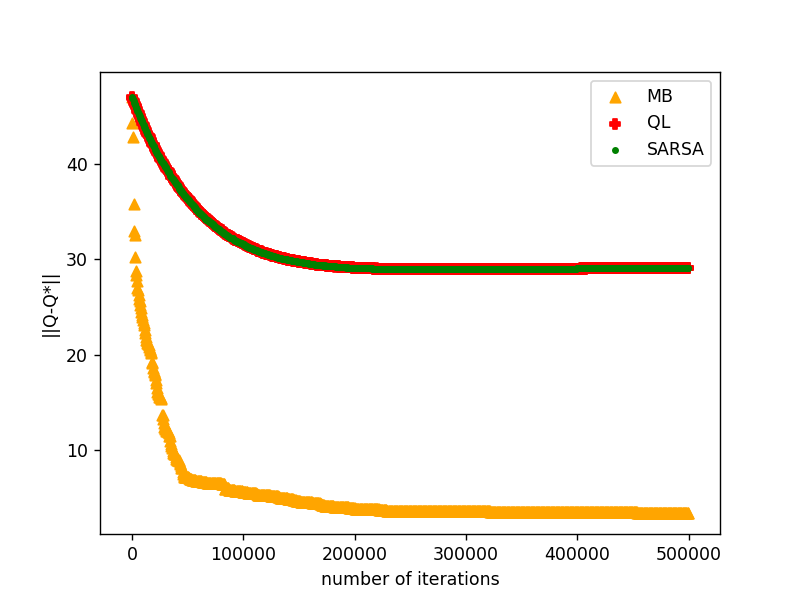

In [112]:
import matplotlib.patches as mpatches

fig = plt.figure()
ax = fig.add_subplot(111)

x=[i for i in range(0,number_iterations,500)]

m = plt.scatter(x, model,color="orange",marker ="^",label="MB")
a = plt.scatter(x, q_learn,color="red",marker="P",label="QL")
q = plt.scatter(x, sarsa,color="green",marker=".",label="SARSA")

plt.legend(handles=[m,a,q])

ax.set_xlabel('number of iterations')
ax.set_ylabel('||Q-Q*||')

plt.show()